In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import api as pyq 

In [27]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mc = run_casci(scf_checkfile, nroots=4)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1

WARN: Mulitple states found in CASCI solver. First state is used to compute the Fock matrix and natural orbitals in active space.

CASCI state   0  E = -2.87015742152925  E(CI) = -2.87015742152925  S^2 = 0.0000000
CASCI state   1  E = -1.40116327670131  E(CI) = -1.40116327670131  S^2 = 2.0000000
CASCI state   2  E = -0.950953194776060  E(CI) = -0.950953194776060  S^2 = 0.0000000
CASCI state   3  E = 0.604815912795335  E(CI) = 0.604815912795335  S^2 = 0.0000000
dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mo_coeff', 'ncas', 'nelecas']>


In [28]:
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)

pyq.OPTIMIZE(scf_checkfile, opt_checkfile, ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
# recipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=10, nconfig=500, verbose=False)

# Jastrow optimization results
df = pyq.read_opt(opt_checkfile)
df

iteration_offset 5 >= max_iterations 2; no steps will be run.


,energy,iteration,error,fname
0,-2.818270,0,0.013463,he-sj.hdf5
1,-2.882818,1,0.007495,he-sj.hdf5
2,-2.888663,2,0.003955,he-sj.hdf5
3,-2.888468,3,0.004034,he-sj.hdf5
4,-2.905630,4,0.004084,he-sj.hdf5


In [29]:
#ABVMC with jastrows
#
#
abvmc_file = 'abvmc-j-001.hdf5'
for fname in [abvmc_file]:
    if os.path.isfile(fname):
        os.remove(fname)
import importlib, recipes, bosonrecipes, bosonenergy
modules = [recipes, bosonrecipes, bosonenergy]
for m in modules:
    importlib.reload(m)

nblocks = 100
nsteps_per_block = 10
tstep=0.3
nconfig=1000
bosonrecipes.ABVMC(scf_checkfile, 
                  abvmc_file, 
                  load_parameters=opt_checkfile, verbose=True,  
                  nblocks=nblocks, 
                  nsteps_per_block=nsteps_per_block,
                  tstep= tstep, 
                  nconfig=nconfig)

Number of determinants in the bosonic wavefunction= 1
Using spherical guess
----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

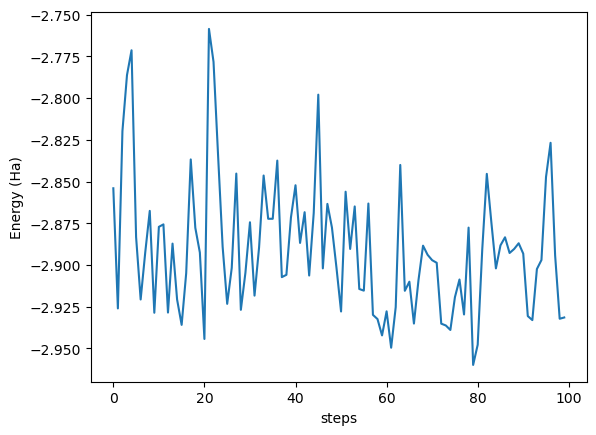

In [30]:
with h5py.File(abvmc_file) as f:
    etot_abvmc = f['energytotal'][...] 
plt.plot(etot_abvmc)
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

In [31]:
#PYQMC VMC with jastrow
#
#
vmc_file = 'vmc-j-001.hdf5'
for fname in [vmc_file]:
    if os.path.isfile(fname):
        os.remove(fname)
import recipes

recipes.VMC(scf_checkfile, vmc_file, 
    load_parameters=opt_checkfile, verbose=True,  
    nblocks=nblocks, 
    nsteps_per_block=nsteps_per_block,
    tstep= tstep,
    nconfig=nconfig)

----------------------------------------------------------------------------------------------------vmc done


Text(0, 0.5, 'Energy (Ha)')

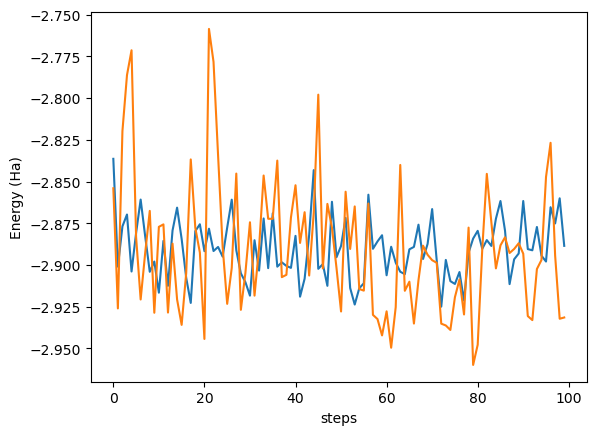

In [32]:
with h5py.File(vmc_file) as f:
    etot_vmc = f['energytotal'][...] 
plt.plot(etot_vmc)
plt.plot(etot_abvmc)
plt.xlabel('steps')
plt.ylabel('Energy (Ha)')

Mean  etot_j ,  -14.092392006262537 +/- 0.8951337011213625
Mean  ee_j ,  4.336860765012042 +/- 0.02964974451694474
Mean  ei_j ,  -33.46668122355665 +/- 4.158025434123524
Mean  ke_j ,  15.037428452282063 +/- 6.659595340085532


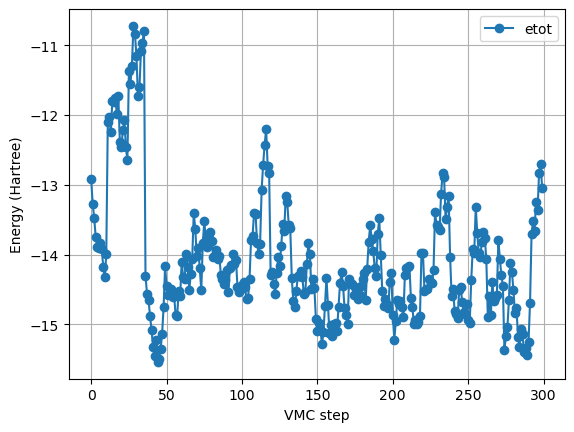

In [66]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

import matplotlib.pyplot as plt
with h5py.File("vmc-j-001.hdf5") as f:
    ee_j = f['energyee'][...]   
    ei_j = f['energyei'][...]
    # ii = f['energyii'][...]    
    ke_j = f['energyke'][...]
    etot_j = f['energytotal'][...]
plt.plot(etot_j, marker='o', label="etot")
# plt.plot(ee_j, marker='o', label="ee")
# plt.plot(ei_j, marker='o', label="ei")
# plt.plot(ke_j, marker='o', label="ke")

# plt.plot(vxc-vxc[0], marker='o', label="vxc")
plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.xlim((200,500))
# plt.ylim((-10, 5))
plt.grid()
# plt.figure()
discard = 10
for e in [etot_j, ee_j, ei_j, ke_j]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    print("Mean ", namestr(e, globals())[0], ", ", e_m, "+/-", e_d)

# e_m = np.mean(etot[discard:])
# e_d = np.var(etot[discard:])
# # e_m2 = np.mean(etot2[discard:])
# # e_d2 = np.var(etot2[discard:])
# print("Mean VMC Energy, ", e_m, "+/-", e_d)
# print("LDA Energy, ", mf.energy_tot())
# plt.plot(ed, marker='o', label="ke")

# print('ee', np.mean(ee[discard:]))
# print('ei', np.mean(ei[discard:]))
# print('ke', np.mean(ke[discard:]))


In [89]:
#ABVMC with jastrows
#
#
import importlib, multiplywf, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
# Jastrow optimization
for fname in ['abvmc-j-001.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
from recipes import ABDMC, DMC, ABVMC, VMC

ABVMC("scf.hdf5", "abvmc-j-001.hdf5", 
      load_parameters="sj.hdf5", verbose=True,  
      nblocks=nblocks, 
      nsteps_per_block=nsteps_per_block,
      tstep= tstep, 
      nconfig=nconfig)

Number of determinants in the bosonic wavefunction= 1
Using spherical guess
-> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/jastrowspin.py(911)gradient_laplacian()
    909         import pdb
    910         pdb.set_trace()
--> 911         return gpu.asnumpy(grad), gpu.asnumpy(lap + gpu.cp.sum(grad**2, axis=0))
    912 
    913     def pgradient(self):



ipdb>  grad.shape


(3, 100)


ipdb>  gpu.cp.sum(grad**2, axis=0).shape


(100,)


ipdb>  exit


Mean  etot_j_abvmc ,  -7.58366150233924 +/- 0.05046229621105134
LDA Energy,  -7.34320268053483


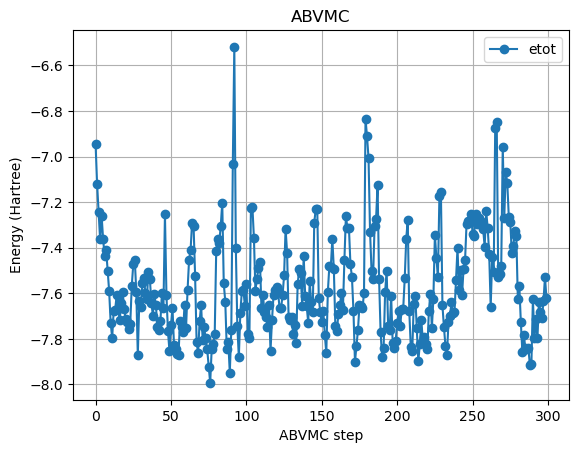

In [88]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-j-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_j_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc

plt.plot(etot_j_abvmc, marker='o', label="etot")

plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_j_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
print("LDA Energy, ", mf_lda.energy_tot())



Mean  etot_j_abvmc ,  -10.385957831740832 +/- 1.076490875239629
LDA Energy,  -7.34320268053483


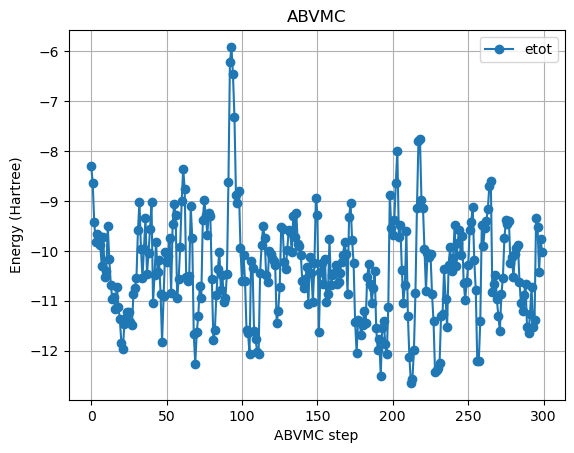

In [84]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
import matplotlib.pyplot as plt
with h5py.File("abvmc-j-001.hdf5") as f:
    ee_abvmc = f['energyee'][...]   
    ei_abvmc = f['energyei'][...]
    vh_abvmc = f['energyvh'][...]   
    vxc_abvmc = f['energyvxc'][...]       
    # eid = f['energyeid'][...]    
    ii_abvmc = f['energyii'][...]    
    ke_abvmc = f['energyke'][...]
    ka_abvmc = f['energyka'][...]
    kb_abvmc = f['energykb'][...]   
    ecorr_abvmc = f['energycorr'][...]    
    etot_j_abvmc = f['energytotal'][...] 
vhxc_abvmc = vh_abvmc + vxc_abvmc

plt.plot(etot_j_abvmc, marker='o', label="etot")

plt.legend()
plt.xlabel("ABVMC step")
plt.ylabel("Energy (Hartree)")
plt.grid()
plt.title('ABVMC')
for e in [etot_j_abvmc]:
    e_m = np.mean(e[discard:])
    e_d = np.var(e[discard:])
    nn = namestr(e, globals())
    name = nn[0] if nn[0] != 'e' else nn[1]
    print("Mean ", name, ", ", e_m, "+/-", e_d)
print("LDA Energy, ", mf_lda.energy_tot())



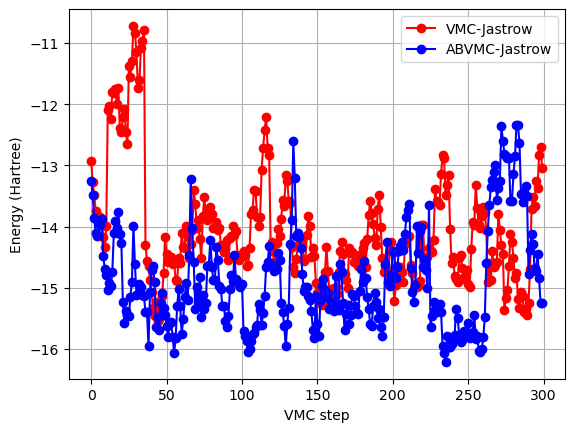

In [69]:
plt.plot(etot_j, marker='o', color = 'r', label="VMC-Jastrow")
plt.plot(etot_j_abvmc, marker='o', color='b', label="ABVMC-Jastrow")

plt.legend()
plt.xlabel("VMC step")
plt.ylabel("Energy (Hartree)")
# plt.ylim((-1.4, -1))
# discard =  1000
# plt.axvline(discard, linestyle='dashed')
# plt.axhline(np.mean(etot_j[discard:]), color='r')
# plt.axhline(np.mean(etot_j_abvmc[discard:]), color='b')
plt.grid()
